In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\josit\AppData\Roaming\nltk_data...


True

In [36]:
texto = "El banco BBVA ha tenido un gran trimestre y sus acciones suben mucho."
sentimiento = sia.polarity_scores(texto)
print(sentimiento)


{'neg': 0.0, 'neu': 0.821, 'pos': 0.179, 'compound': 0.34}


In [ ]:
# Ruta al archivo CSV
file_path = "../data/csv/communications.csv"

# Leer CSV
df = pd.read_csv(file_path, quotechar='"')


         Date Release Date       Type  \
0  2025-05-07   2025-05-28     Minute   
1  2025-05-07   2025-05-07  Statement   
2  2025-03-19   2025-03-19  Statement   
3  2025-03-19   2025-04-09     Minute   
4  2025-01-29   2025-01-29  Statement   

                                                Text  
0  Minutes of the Federal Open Market Committee\n...  
1  Although swings in net exports have affected t...  
2  Recent indicators suggest that economic activi...  
3  Minutes of the Federal Open Market Committee\n...  
4  Recent indicators suggest that economic activi...  
Minutes of the Federal Open Market Committee
                                                
                    
                    
                    
                    May 6â7, 2025 
A joint meeting of the Federal Open Market Committee and the Board of Governors of the Federal Reserve System was held in the offices of the Board of Governors on Tuesday, May 6, 2025, at 8:30 a.m. and continued on Wednesday, May

In [39]:

# Mostrar las primeras filas
df.head()


,Date,Release Date,Type,Text
0,2025-05-07,2025-05-28,Minute,Minutes of the Federal Open Market Committee\n...
1,2025-05-07,2025-05-07,Statement,Although swings in net exports have affected t...
2,2025-03-19,2025-03-19,Statement,Recent indicators suggest that economic activi...
3,2025-03-19,2025-04-09,Minute,Minutes of the Federal Open Market Committee\n...
4,2025-01-29,2025-01-29,Statement,Recent indicators suggest that economic activi...


In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Crear el analizador
sia = SentimentIntensityAnalyzer()


In [21]:
import yfinance as yf
import pandas as pd

# -----------------------------
# CONFIGURACIÓN
# -----------------------------
tickers = ['SAN.MC', 'BBVA.MC']
period = 'max'
interval = '1d'

# -----------------------------
# DESCARGAR DATOS
# -----------------------------
# auto_adjust=False para que Close sea el precio real
data = yf.download(tickers, period=period, interval=interval, auto_adjust=False)

# -----------------------------
# FUNCIONES AUXILIARES
# -----------------------------
def add_features(df):
    # Rango diario
    df['range'] = df['high'] - df['low']
    
    # Retornos diarios
    df['return'] = df['close'].pct_change()
    
    # SMA 5 y 10 días
    df['sma_5'] = df['close'].rolling(window=5).mean()
    df['sma_10'] = df['close'].rolling(window=10).mean()
    
    # Volumen relativo (comparado con media de 10 días)
    df['vol_rel'] = df['volume'] / df['volume'].rolling(window=10).mean()
    
    # Solo eliminar filas donde Close sea NaN (no por rolling)
    df = df[df['close'].notna()]
    
    return df

# -----------------------------
# PROCESAR Y GUARDAR POR TICKER
# -----------------------------
for ticker in tickers:
    # Seleccionar columnas de cada ticker usando xs
    df = data.xs(ticker, level=1, axis=1).copy()
    
    # Renombrar columnas a minúsculas
    df.columns = [col.lower() for col in df.columns]
    
    # Añadir features adicionales
    df = add_features(df)
    
    # Guardar CSV
    df.to_csv(f'{ticker.replace(".MC","")}_features.csv')
    print(f'CSV generado: {ticker.replace(".MC","")}_features.csv')


[*********************100%***********************]  2 of 2 completed


CSV generado: SAN_features.csv
CSV generado: BBVA_features.csv


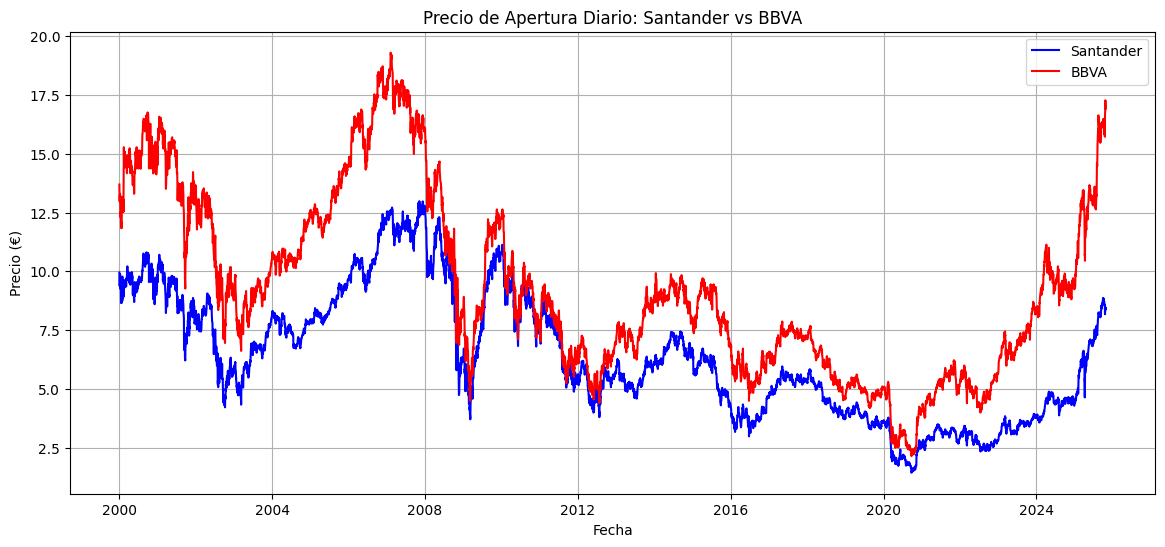

In [22]:
# Cargar CSV
df_san = pd.read_csv('..\data\csv\SAN_features.csv', index_col=0, parse_dates=True)
df_bbva = pd.read_csv('..\data\csv\BBVA_features.csv', index_col=0, parse_dates=True)

# Graficar precio de apertura
plt.figure(figsize=(14,6))
plt.plot(df_san.index, df_san['open'], label='Santander', color='blue')
plt.plot(df_bbva.index, df_bbva['open'], label='BBVA', color='red')

plt.title('Precio de Apertura Diario: Santander vs BBVA')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.legend()
plt.grid(True)
plt.show()


In [23]:


# Cargar CSV
df_san = pd.read_csv('..\\data\\csv\\SAN_features.csv', index_col=0, parse_dates=True)
df_bbva = pd.read_csv('..\\data\\csv\\BBVA_features.csv', index_col=0, parse_dates=True)

# Eliminar filas con NaN
df_san = df_san.dropna()
df_bbva = df_bbva.dropna()

# Seleccionar solo valores numéricos
features_san = df_san.values
features_bbva = df_bbva.values

# Normalizar
scaler_san = MinMaxScaler()
features_san_scaled = scaler_san.fit_transform(features_san)

scaler_bbva = MinMaxScaler()
features_bbva_scaled = scaler_bbva.fit_transform(features_bbva)

# Comprobación rápida
print("SAN min/max:", np.min(features_san_scaled), np.max(features_san_scaled))
print("BBVA min/max:", np.min(features_bbva_scaled), np.max(features_bbva_scaled))


SAN min/max: 0.0 1.0
BBVA min/max: 0.0 1.0000000000000002


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# -----------------------------
# Dataset con ventana de días
# -----------------------------
def create_windowed_dataset(features, target_col_index=-3, window_size=5):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i+window_size])
        y.append(features[i+window_size][target_col_index])
    return np.array(X), np.array(y).reshape(-1,1)

window_size = 5
X_san, y_san = create_windowed_dataset(features_san_scaled, window_size=window_size)
X_bbva, y_bbva = create_windowed_dataset(features_bbva_scaled, window_size=window_size)

# -----------------------------
# Convertir a tensores y pasar a GPU
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_san_t = torch.tensor(X_san, dtype=torch.float32).to(device)
y_san_t = torch.tensor(y_san, dtype=torch.float32).to(device)

X_bbva_t = torch.tensor(X_bbva, dtype=torch.float32).to(device)
y_bbva_t = torch.tensor(y_bbva, dtype=torch.float32).to(device)

# -----------------------------
# DataLoader
# -----------------------------
batch_size = 64
san_loader = DataLoader(TensorDataset(X_san_t, y_san_t), batch_size=batch_size, shuffle=True)
bbva_loader = DataLoader(TensorDataset(X_bbva_t, y_bbva_t), batch_size=batch_size, shuffle=True)

# -----------------------------
# Modelo LSTM
# -----------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # salida del último timestep

input_dim = X_san_t.shape[2]  # número de features
model_san = LSTMModel(input_dim).to(device)
model_bbva = LSTMModel(input_dim).to(device)

# -----------------------------
# Entrenamiento
# -----------------------------
criterion = nn.MSELoss()
optimizer_san = optim.Adam(model_san.parameters(), lr=0.001)
optimizer_bbva = optim.Adam(model_bbva.parameters(), lr=0.001)

num_epochs = 500  # puedes subirlo si quieres

for epoch in range(1, num_epochs+1):
    # Santander
    epoch_loss_san = 0
    for xb, yb in san_loader:
        optimizer_san.zero_grad()
        output = model_san(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer_san.step()
        epoch_loss_san += loss.item() * xb.size(0)
    epoch_loss_san /= len(san_loader.dataset)
    
    # BBVA
    epoch_loss_bbva = 0
    for xb, yb in bbva_loader:
        optimizer_bbva.zero_grad()
        output = model_bbva(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer_bbva.step()
        epoch_loss_bbva += loss.item() * xb.size(0)
    epoch_loss_bbva /= len(bbva_loader.dataset)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Loss SAN: {epoch_loss_san:.6f}, Loss BBVA: {epoch_loss_bbva:.6f}")


Epoch 10/500 - Loss SAN: 0.000062, Loss BBVA: 0.000026
Epoch 20/500 - Loss SAN: 0.000014, Loss BBVA: 0.000013
Epoch 30/500 - Loss SAN: 0.000013, Loss BBVA: 0.000022
Epoch 40/500 - Loss SAN: 0.000019, Loss BBVA: 0.000016
Epoch 50/500 - Loss SAN: 0.000013, Loss BBVA: 0.000011
Epoch 60/500 - Loss SAN: 0.000012, Loss BBVA: 0.000010
Epoch 70/500 - Loss SAN: 0.000018, Loss BBVA: 0.000014
Epoch 80/500 - Loss SAN: 0.000013, Loss BBVA: 0.000010
Epoch 90/500 - Loss SAN: 0.000013, Loss BBVA: 0.000010
Epoch 100/500 - Loss SAN: 0.000013, Loss BBVA: 0.000010
Epoch 110/500 - Loss SAN: 0.000014, Loss BBVA: 0.000019
Epoch 120/500 - Loss SAN: 0.000012, Loss BBVA: 0.000011
Epoch 130/500 - Loss SAN: 0.000012, Loss BBVA: 0.000011
Epoch 140/500 - Loss SAN: 0.000015, Loss BBVA: 0.000010
Epoch 150/500 - Loss SAN: 0.000010, Loss BBVA: 0.000008
Epoch 160/500 - Loss SAN: 0.000012, Loss BBVA: 0.000011
Epoch 170/500 - Loss SAN: 0.000010, Loss BBVA: 0.000009
Epoch 180/500 - Loss SAN: 0.000010, Loss BBVA: 0.000011
E

In [29]:
# -----------------------------
# Predecir los próximos 5 días
# -----------------------------
model_san.eval()  # modo evaluación
preds_san = []

# Tomamos el último vector de features del dataset
last_input = X_san_t[-1].unsqueeze(0)  # tamaño [1, num_features]

with torch.no_grad():
    for _ in range(5):
        pred = model_san(last_input)          # predicción del siguiente día
        preds_san.append(pred.item())         # guardamos valor
        # Actualizamos last_input: desplazamos y añadimos la predicción en la columna 'close'
        last_input = last_input.clone()
        last_input[0, -3] = pred.item()      # suponiendo que 'close' es columna -3

preds_san = np.array(preds_san).reshape(-1,1)


In [26]:
import numpy as np

# Creamos un array temporal con ceros que tenga todas las columnas que espera el scaler
temp = np.zeros((len(preds_san), features_san_scaled.shape[1]))

# Ponemos la predicción en la columna 'close' (supongamos que era la -3)
temp[:, -3] = preds_san.flatten()  

# Desnormalizamos
preds_san_descaled = scaler_san.inverse_transform(temp)[:, -3]  # solo columna 'close'

print("Predicción de 5 días (SAN) en precios reales:")
print(preds_san_descaled)


Predicción de 5 días (SAN) en precios reales:
[8.42526064 8.52813826 8.55242898 8.55810022 8.55905607]


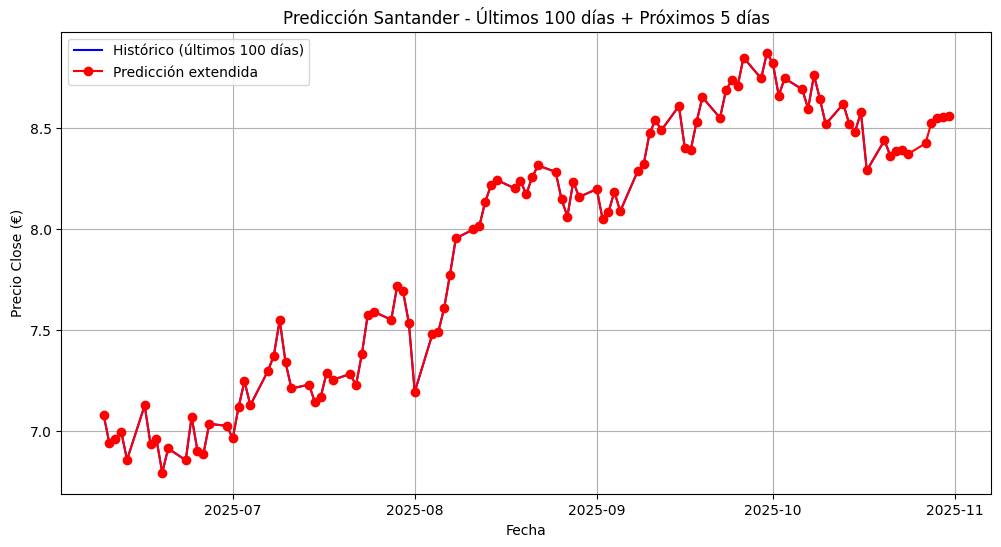

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -----------------------------
# Datos históricos últimos 100 días
# -----------------------------
historical_dates = df_san.index[-100:]
historical_prices = df_san['close'][-100:]

# -----------------------------
# Construir predicción extendida: últimos 100 días + próximos 5
# -----------------------------
# Tomamos los últimos 100 valores históricos
pred_prices_full = np.concatenate((historical_prices.values, preds_san_descaled.flatten()))

# Fechas correspondientes: últimos 100 días + 5 días futuros
pred_dates_full = pd.date_range(historical_dates[0], periods=105, freq='B')

# -----------------------------
# Gráfico
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(historical_dates, historical_prices, label='Histórico (últimos 100 días)', color='blue')
plt.plot(pred_dates_full, pred_prices_full, label='Predicción extendida', color='red', marker='o')
plt.title('Predicción Santander - Últimos 100 días + Próximos 5 días')
plt.xlabel('Fecha')
plt.ylabel('Precio Close (€)')
plt.legend()
plt.grid(True)
plt.show()
